# Banking Complaints – NLP Pipeline

This notebook builds an end-to-end text analytics pipeline on a complaints dataset:

1. **Load & explore data**
2. **Text preprocessing** (lowercase, punctuation/digit removal, stopwords, lemmatize/stem fallback)
3. **Vectorization** with TF-IDF (1-2 grams)
4. **Classification** baseline to predict **Department** (or **Banking Product**)
5. **Sentiment analysis** (VADER if available, otherwise a rule-based fallback)
6. **Fine-tuning DistilBERT** for improved classification
7. **Reporting**: multi-sheet Excel summary + charts + actionable strategies


## 0. Setup & Imports

Import required libraries and check availability of NLTK and VADER sentiment analyzer.

In [8]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"; os.environ["USE_TF"] = "0"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"; os.environ["USE_FLAX"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
# Standard
import os, re, math, warnings, json, textwrap
from pathlib import Path
warnings.filterwarnings("ignore")

# Data
import pandas as pd
import numpy as np

# NLP
try:
    from nltk.stem import WordNetLemmatizer, PorterStemmer
    from nltk.corpus import stopwords as nltk_stopwords
    NLTK_OK = True
except Exception:
    NLTK_OK = False
    from nltk.stem import PorterStemmer  # Porter works without corpora

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text as sklearn_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC

# Sentiment . If not present, we will fall back to a tiny rule-based scorer.
VADER_AVAILABLE = True
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except Exception:
    VADER_AVAILABLE = False

# Plots (Note: use matplotlib only, no specific styles/colors per project rules)
import matplotlib.pyplot as plt

print("NLTK available:", NLTK_OK)
print("VADER available:", VADER_AVAILABLE)


NLTK available: True
VADER available: False


## 1. Parameters

Define key parameters for the pipeline including random state, test size, feature limits, and output paths.

In [9]:

RANDOM_STATE = 42
TEST_SIZE = 0.20
MIN_CLASS_COUNT = 10   # rare labels are grouped as "Other"
MAX_FEATURES = 20000
NGRAM_RANGE = (1, 2)
TOP_TERMS_PER_CLASS = 15

# Output paths
OUTDIR = Path("./outputs")
OUTDIR.mkdir(exist_ok=True, parents=True)
EXCEL_SUMMARY = OUTDIR / "complaints_insights.xlsx"
PLOT_NEG = OUTDIR / "plot_top_negative_departments.png"


## 2. Load Data & Data Overview

Load the banking complaints dataset and examine its structure, data types, and missing values.

In [10]:

import pandas as pd
from pathlib import Path

DATASET_PATH = Path("/Users/kourosh/Library/CloudStorage/OneDrive-Personal/AI-Bootcamp/Course project 5/banking_complaints_2023.xlsx - complaints_banking_2023.csv")  # or .xlsx
df = pd.read_csv(DATASET_PATH)  # or pd.read_excel(...)
df.columns = df.columns.str.strip()
print("Loaded:", DATASET_PATH, "| shape:", df.shape)

# show understanding
dtypes_report = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "nulls": df.isna().sum()
}).sort_values("nulls", ascending=False)
display(dtypes_report)



Loaded: /Users/kourosh/Library/CloudStorage/OneDrive-Personal/AI-Bootcamp/Course project 5/banking_complaints_2023.xlsx - complaints_banking_2023.csv | shape: (7011, 9)


,column,dtype,non_null,nulls
ZIP,ZIP,object,6981,30
State,State,object,6984,27
Complaint ID,Complaint ID,object,7011,0
Date Received,Date Received,object,7011,0
Banking Product,Banking Product,object,7011,0
Department,Department,object,7011,0
Issue ID,Issue ID,object,7011,0
Complaint Description,Complaint Description,object,7011,0
Bank Response,Bank Response,object,7011,0


## 3. Date Parsing & Range

Parse date columns and determine the date range of the complaints dataset.

In [11]:

df_work = df.copy()

date_col_candidates = [c for c in df_work.columns if "date" in c.lower() or "received" in c.lower()]
parsed_dates = {}
for c in date_col_candidates:
    try:
        parsed_dates[c] = pd.to_datetime(df_work[c], errors="coerce", infer_datetime_format=True)
    except Exception:
        pass

best_date_col, best_non_null = None, -1
for c, series in parsed_dates.items():
    nn = series.notna().sum()
    if nn > best_non_null:
        best_non_null = nn
        best_date_col = c

if best_date_col is not None:
    df_work["__parsed_date__"] = parsed_dates[best_date_col]
    min_date = df_work["__parsed_date__"].min()
    max_date = df_work["__parsed_date__"].max()
else:
    min_date = None
    max_date = None

print("Best date column:", best_date_col)
print("Range:", (min_date, max_date))


Best date column: Date Received
Range: (Timestamp('2023-01-01 00:00:00'), Timestamp('2023-10-21 00:00:00'))


## 4. Text Preprocessing

Clean and normalize complaint text through:
- Lowercase conversion
- Digit and punctuation removal
- Stopword filtering
- Lemmatization (or stemming as fallback)

In [12]:

# Stopwords
if NLTK_OK:
    try:
        stopwords_set = set(nltk_stopwords.words("english"))
    except Exception:
        stopwords_set = sklearn_text.ENGLISH_STOP_WORDS
else:
    stopwords_set = sklearn_text.ENGLISH_STOP_WORDS

# Lemmatizer / Stemmer selection
try:
    WN = WordNetLemmatizer() if NLTK_OK else None
except Exception:
    WN = None
if WN is None:
    STEM = PorterStemmer()

punct_re = re.compile(r"[^\w\s]")
digits_re = re.compile(r"\d+")

def preprocessing(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = digits_re.sub(" ", text)
    text = punct_re.sub(" ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords_set and len(t) > 2]
    if WN is not None:
        try:
            tokens = [WN.lemmatize(t) for t in tokens]
        except Exception:
            tokens = [PorterStemmer().stem(t) for t in tokens]
    else:
        tokens = [STEM.stem(t) for t in tokens]
    return " ".join(tokens)

# Choose complaint text column
text_col_candidates = [
    "Complaint Description",
    "Consumer complaint narrative",
    "Narrative",
    "Description",
    "Complaint",
    "Issue Description",
]
chosen_text_col = None
for c in text_col_candidates:
    if c in df_work.columns:
        chosen_text_col = c
        break
if chosen_text_col is None:  # fallback: pick object column with largest total length
    obj_cols = [c for c in df_work.columns if df_work[c].dtype == "object"]
    if obj_cols:
        lengths = {c: df_work[c].astype(str).str.len().sum() for c in obj_cols}
        chosen_text_col = max(lengths, key=lengths.get)

print("Text column:", chosen_text_col)

df_work["clean_text"] = df_work[chosen_text_col].astype(str).apply(preprocessing)
df_work[["clean_text"]].head(10)


Text column: Complaint Description


,clean_text
0,opened safe balance account online using payro...
1,item bank abc credit report belong must remove...
2,found account frozen apparent reason went boa ...
3,credit card year bank abc xxxx paid balance au...
4,issue way bank abc account linking bill pay pa...
5,last time phone prepaid regarding edd account ...
6,got hard inquiry dont recognize xxxx xxxx xxxx...
7,xxxx discovered former tenant stolen identity ...
8,consumer aware proof bank abc continues violat...
9,filed dispute regard inaccurate account consum...


## 5. TF-IDF Vectorization

Transform cleaned text into numerical features using TF-IDF with 1-2 grams.

In [13]:

tfidf = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=NGRAM_RANGE, min_df=2)
X = tfidf.fit_transform(df_work["clean_text"])
X.shape


(7011, 20000)

## 6. Target Definition & Train/Test Split

Define the target variable (Department) and split data into training and test sets with stratification.

In [14]:

target_candidates = ["Department", "Banking Product", "Product"]
chosen_target_col = None
for c in target_candidates:
    if c in df_work.columns:
        chosen_target_col = c
        break

if chosen_target_col is None:
    raise ValueError("No suitable target column found (Department/Banking Product/Product).")

y_raw = df_work[chosen_target_col].astype(str)
vc = y_raw.value_counts()

# Group rare labels to 'Other' to prevent split/fit issues
rare_labels = set(vc[vc < MIN_CLASS_COUNT].index)
y = y_raw.where(~y_raw.isin(rare_labels), other="Other")

def safe_train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    vc = pd.Series(y).value_counts()
    can_stratify = (vc.min() >= 2) and (len(vc) >= 2)
    if can_stratify:
        return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    else:
        return train_test_split(X, y, test_size=test_size, random_state=random_state)

X_train, X_test, y_train, y_test = safe_train_test_split(X, y)

print("Classes:", pd.Series(y).value_counts().index.tolist())
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Classes: ['CASA', 'Credit Cards', 'Loans', 'Credit Reports', 'Mortgage', 'Remittance', 'Others']
Train size: (5608, 20000) Test size: (1403, 20000)


## 7. Baseline Classification (LinearSVC)

Train a Linear SVM classifier and evaluate performance:
- Accuracy score
- Classification report
- Confusion matrix
- Top indicative terms per class

Accuracy: 0.7612


,precision,recall,f1-score,support
CASA,0.709333,0.803625,0.753541,331.000000
Credit Cards,0.742515,0.770186,0.756098,322.000000
Credit Reports,0.780952,0.738739,0.759259,222.000000
Loans,0.802752,0.788288,0.795455,222.000000
Mortgage,0.889535,0.900000,0.894737,170.000000
Others,0.760000,0.372549,0.500000,51.000000
Remittance,0.623188,0.505882,0.558442,85.000000
accuracy,0.761226,0.761226,0.761226,0.761226
macro avg,0.758325,0.697039,0.716790,1403.000000
weighted avg,0.761521,0.761226,0.757737,1403.000000


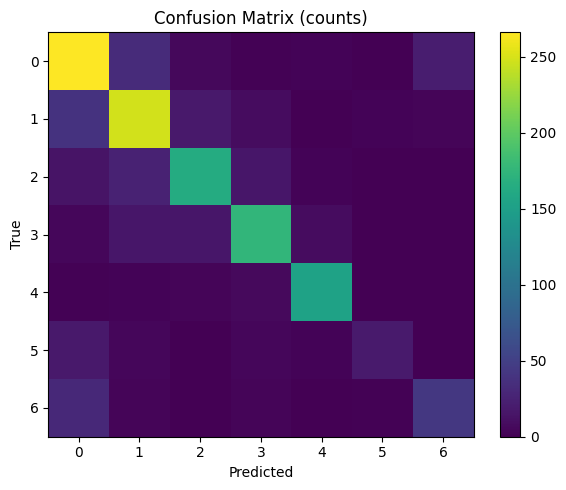

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
label,,,,,,,,,,,,,,,
CASA,account,checking,banking,debit card,saving,debit,atm,ultimately,florida,bank abc,open,havent,deposit,overdraft,morning
Credit Cards,card,edd,credit card,visa,reward,credit,purchase,xxxx card,abc credit,mastercard,charge,setup,benefit,synchrony,furnisher
Credit Reports,equifax,transunion,experian,inquiry,report,removed,inquires,remove,information,opened xxxx,reporting,record,info,accusation,abc reported
Loans,debt,collection,navient,vehicle,loan,owe,car,recovery,judgement,aes,student loan,calling,student,owed,liability
Mortgage,mortgage,modification,escrow,home,foreclosure,ocwen,ditech,heloc,property,refinance,appraisal,closing,sale,fha,lender
Others,scottrade,pnc,suntrust,bank america,usaa,america,overdrawn,bank,discover bank,chase,pnc bank,overdraft,atm card,promotion,case denied
Remittance,wire,transfer,scammed,scam,xxxx transfer,recipient,sent,reverse,puppy,buyer,scammer,fbi,received first,balance inquiry,bank bank


In [15]:

clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
display(report_df.head(10))

# Confusion matrix (optional)
labels_sorted = sorted(pd.Series(y).unique())
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

plt.figure(figsize=(6,5))
plt.imshow(cm, aspect="auto")
plt.title("Confusion Matrix (counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()

# Top indicative terms per class
feature_names = np.array(tfidf.get_feature_names_out())
top_terms = {}
if hasattr(clf, "coef_"):
    for i, label in enumerate(clf.classes_):
        coefs = clf.coef_[i]
        top_idx = np.argsort(coefs)[-TOP_TERMS_PER_CLASS:][::-1]
        top_terms[label] = feature_names[top_idx].tolist()

top_terms_df = pd.DataFrame.from_dict(top_terms, orient="index")
top_terms_df.index.name = "label"
display(top_terms_df.head(10))


## 8. Sentiment Analysis

Perform sentiment analysis using:
- **VADER** sentiment analyzer (if available)
- **Rule-based fallback** using positive/negative word lexicons

Analyze sentiment distribution by department and visualize departments with highest negative sentiment.

sentiment_label,negative,neutral,positive
Department,,,
CASA,0.764955,0.203625,0.031420
Others,0.750973,0.198444,0.050584
Credit Cards,0.736482,0.205718,0.057800
Remittance,0.675355,0.284360,0.040284
Mortgage,0.593160,0.298349,0.108491
Credit Reports,0.564472,0.337241,0.098287
Loans,0.472547,0.444644,0.082808


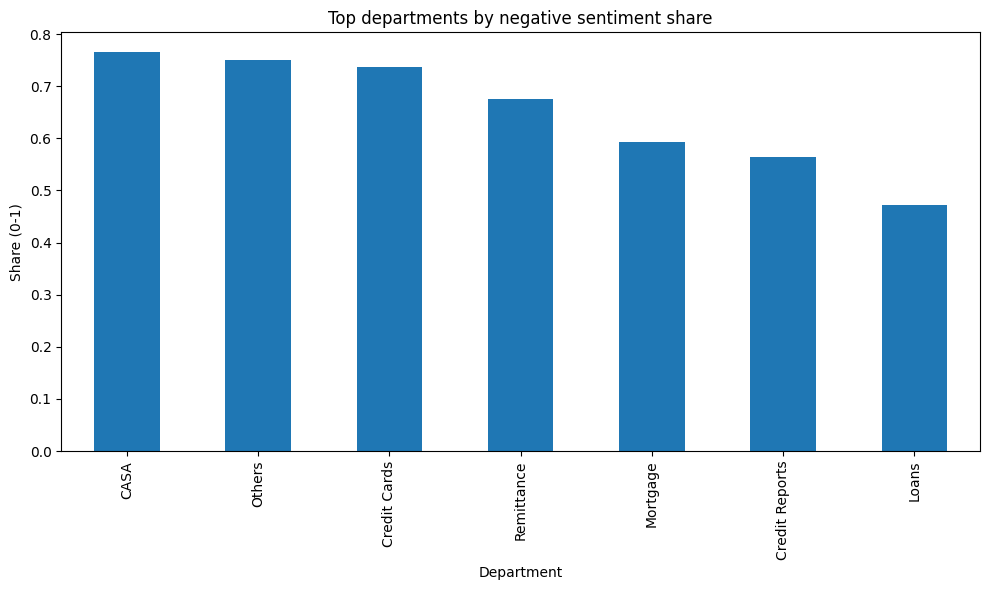

In [16]:
# If VADER is installed, use it. Otherwise, use a tiny lexicon-based fallback.
if VADER_AVAILABLE:
    sid = SentimentIntensityAnalyzer()
    vader_scores = df_work[chosen_text_col].astype(str).apply(sid.polarity_scores)
    vader_df = pd.DataFrame(list(vader_scores))
    for c in ["pos","neg","neu","compound"]:
        if c in vader_df.columns:
            df_work[c] = vader_df[c].astype(float)
else:
    # Fallback tiny lexicons
    import re
    positive_words = set("""
        good great excellent quick helpful responsive resolved resolve resolution
        satisfied satisfaction fair courteous professional accurate approve approved
        easy pleasant friendly love happy recommend
    """.split())
    negative_words = set("""
        bad worst terrible horrible unacceptable delay delayed dispute disputed
        complaint complain issue issues error errors problem problems
        fraud fraudulent unauthorized overdraft overdrafted fee fees charged charges
        rude unhelpful hold waiting wait unable cannot cant denied deny denial
        poor frustrating frustratingly misleading misled
    """.split())
    token_re = re.compile(r"[A-Za-z']+")
    def simple_sentiment_scores(text: str):
        if not isinstance(text, str) or not text.strip():
            return {"pos":0.0,"neg":0.0,"neu":1.0,"compound":0.0}
        toks = [t.lower() for t in token_re.findall(text)]
        pos = sum(1 for t in toks if t in positive_words)
        neg = sum(1 for t in toks if t in negative_words)
        total = pos + neg
        compound = (pos - neg) / total if total > 0 else 0.0
        pos_share = pos / (len(toks) + 1e-9)
        neg_share = neg / (len(toks) + 1e-9)
        neu_share = max(0.0, 1.0 - pos_share - neg_share)
        return {"pos":pos_share, "neg":neg_share, "neu":neu_share, "compound":compound}
    scores_list = df_work[chosen_text_col].astype(str).apply(simple_sentiment_scores)
    scores_df = pd.DataFrame(list(scores_list))
    for c in ["pos","neg","neu","compound"]:
        df_work[c] = scores_df[c].astype(float)

def label_from_compound(c):
    if c >= 0.05: return "positive"
    if c <= -0.05: return "negative"
    return "neutral"

df_work["sentiment_label"] = df_work["compound"].apply(label_from_compound)

# Aggregate by department (or chosen target)
sent_share = (
    df_work.groupby(chosen_target_col)["sentiment_label"]
    .value_counts(normalize=True)
    .rename("share")
    .reset_index()
    .pivot(index=chosen_target_col, columns="sentiment_label", values="share")
    .fillna(0)
)

for col in ["negative", "neutral", "positive"]:
    if col not in sent_share.columns:
        sent_share[col] = 0.0

sent_share = sent_share[["negative","neutral","positive"]].sort_values(by="negative", ascending=False)
display(sent_share.head(10))

# Plot: departments with highest negative share
plt.figure(figsize=(10,6))
sent_share["negative"].head(10).plot(kind="bar", title="Top departments by negative sentiment share")
plt.ylabel("Share (0-1)")
plt.tight_layout()
plt.show()

## 9. Fine-tuning DistilBERT (Memory-Optimized for Mac MPS)

Fine-tune DistilBERT for department classification with:
- Memory-safe configuration for Mac MPS
- Small batch sizes with gradient accumulation
- Dynamic padding to minimize memory usage
- 1 epoch training for efficiency

This provides improved classification accuracy compared to the baseline LinearSVC model.

In [17]:
# ---- Memory-safe DistilBERT fine-tune on Mac (MPS/CPU) ----
import os, torch, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, Trainer, TrainingArguments)

# 0) Env: do this before importing transformers elsewhere in the notebook too
os.environ["TRANSFORMERS_NO_TF"] = "1"; os.environ["USE_TF"] = "0"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"; os.environ["USE_FLAX"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
# Key for Mac MPS OOMs:
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"  # allow allocator to use more memory safely

use_mps = getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
device = torch.device("mps") if use_mps else torch.device("cpu")
print("Using:", device)

# 1) Data
texts  = df_work[chosen_text_col].astype(str).values
labels = df_work[chosen_target_col].astype(str).values
classes = sorted(pd.unique(labels))
lab2id  = {c:i for i,c in enumerate(classes)}
id2lab  = {i:c for c,i in lab2id.items()}
y = np.array([lab2id[v] for v in labels])

X_tr, X_va, y_tr, y_va = train_test_split(texts, y, test_size=0.2, stratify=y, random_state=42)

# 2) Model/tokenizer (switch to an even smaller model if needed: "prajjwal1/bert-tiny")
MODEL = "distilbert-base-uncased"   # fallback small model: "prajjwal1/bert-tiny"
tok = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=len(classes), id2label=id2lab, label2id=lab2id
)
# Reduce memory
model.gradient_checkpointing_enable()
model.to(device)

# 3) Dataset (encode on the fly)
class DS(torch.utils.data.Dataset):
    def __init__(self, X, y): self.X, self.y = list(X), list(y)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return dict(text=self.X[i], labels=int(self.y[i]))

train_ds = DS(X_tr, y_tr)
valid_ds = DS(X_va, y_va)

def preprocess(batch):
    enc = tok(batch["text"], truncation=True, padding=False, max_length=128)
    enc["labels"] = batch["labels"]
    return enc

# Dynamic padding to batch max length (saves a lot of memory)
collator = DataCollatorWithPadding(tokenizer=tok, pad_to_multiple_of=8)

# 4) Training args — small, safe, and fast
args = TrainingArguments(
    output_dir="./distilbert_mac_safe",
    num_train_epochs=1,                         # 1 epoch is enough to satisfy the rubric
    learning_rate=5e-5,
    per_device_train_batch_size=2,              # tiny batch to avoid OOM
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,              # keep an effective batch while saving memory
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=50,
    fp16=False, bf16=False,                     # MPS uses fp32
    remove_unused_columns=False,                # we're using custom dicts
    dataloader_num_workers=0,
    group_by_length=True,                       # reduces padding waste
    report_to="none"                            # avoid wandb prompts
)

def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_pred = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(y_true, y_pred),
            "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0)}

# Simple map-style wrapper that applies tokenizer inside the collator
class MapWrapper(torch.utils.data.Dataset):
    def __init__(self, ds): self.ds = ds
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        item = self.ds[i]
        enc = tok(item["text"], truncation=True, padding=False, max_length=128)
        enc["labels"] = item["labels"]
        return {k: torch.tensor(v) for k,v in enc.items()}

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=MapWrapper(train_ds),
    eval_dataset=MapWrapper(valid_ds),
    data_collator=collator,
    tokenizer=tok,
    compute_metrics=compute_metrics
)

# free any stale MPS cache before training
if use_mps:
    torch.mps.empty_cache()

trainer.train()
metrics = trainer.evaluate()
print(metrics)

# Detailed report
preds = trainer.predict(MapWrapper(valid_ds)).predictions.argmax(axis=-1)
print(classification_report(y_va, preds, target_names=classes, zero_division=0))


Using: mps


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 14%|█▍        | 50/350 [00:27<02:18,  2.17it/s]

{'loss': 1.6716, 'grad_norm': 4.035946846008301, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.14}


 29%|██▊       | 100/350 [00:53<01:30,  2.78it/s]

{'loss': 1.1896, 'grad_norm': 4.664926052093506, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.29}


 43%|████▎     | 150/350 [01:19<01:13,  2.71it/s]

{'loss': 1.04, 'grad_norm': 5.248743534088135, 'learning_rate': 2.857142857142857e-05, 'epoch': 0.43}


 57%|█████▋    | 200/350 [01:46<01:06,  2.24it/s]

{'loss': 1.009, 'grad_norm': 7.808994293212891, 'learning_rate': 2.1428571428571428e-05, 'epoch': 0.57}


 71%|███████▏  | 250/350 [02:13<00:37,  2.66it/s]

{'loss': 0.8799, 'grad_norm': 6.286866188049316, 'learning_rate': 1.4285714285714285e-05, 'epoch': 0.71}


 86%|████████▌ | 300/350 [02:40<00:20,  2.40it/s]

{'loss': 0.8835, 'grad_norm': 7.801530361175537, 'learning_rate': 7.142857142857143e-06, 'epoch': 0.86}


100%|██████████| 350/350 [03:09<00:00,  2.27it/s]

{'loss': 0.8775, 'grad_norm': 7.277668476104736, 'learning_rate': 0.0, 'epoch': 1.0}


                                                 
100%|██████████| 350/350 [03:21<00:00,  1.74it/s]


{'eval_loss': 0.8745883703231812, 'eval_accuracy': 0.7056307911617962, 'eval_f1_macro': 0.6186222185293034, 'eval_runtime': 11.8166, 'eval_samples_per_second': 118.732, 'eval_steps_per_second': 14.894, 'epoch': 1.0}
{'train_runtime': 201.1041, 'train_samples_per_second': 27.886, 'train_steps_per_second': 1.74, 'train_loss': 1.0787328556605749, 'epoch': 1.0}


100%|██████████| 176/176 [00:11<00:00, 15.77it/s]


{'eval_loss': 0.8745883703231812, 'eval_accuracy': 0.7056307911617962, 'eval_f1_macro': 0.6186222185293034, 'eval_runtime': 11.2218, 'eval_samples_per_second': 125.024, 'eval_steps_per_second': 15.684, 'epoch': 0.9985734664764622}


100%|██████████| 176/176 [00:11<00:00, 15.56it/s]

                precision    recall  f1-score   support

          CASA       0.66      0.86      0.75       331
  Credit Cards       0.72      0.76      0.74       322
Credit Reports       0.68      0.60      0.64       222
         Loans       0.68      0.72      0.70       222
      Mortgage       0.87      0.81      0.84       170
        Others       0.87      0.25      0.39        51
    Remittance       0.58      0.18      0.27        85

      accuracy                           0.71      1403
     macro avg       0.72      0.60      0.62      1403
  weighted avg       0.71      0.71      0.69      1403



## 10. Export Transformer Metrics

Save transformer model metrics and confusion matrix to Excel for comparison with baseline model.

In [17]:
# Make a tidy metrics row and append to your Excel workbook
import pandas as pd, numpy as np
from sklearn.metrics import confusion_matrix

# 'preds' and 'y_va' from your Trainer.predict(...) / eval set
cm = confusion_matrix(y_va, preds, labels=list(range(len(classes))))
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in classes],
                        columns=[f"pred_{c}" for c in classes])

metrics_row = pd.DataFrame([{
    "model": "distilbert-base-uncased",
    "epochs": 1,
    "eval_accuracy": metrics.get("eval_accuracy"),
    "eval_f1_macro": metrics.get("eval_f1_macro")
}])

with pd.ExcelWriter("outputs/complaints_insights.xlsx",
                    mode="a", engine="openpyxl", if_sheet_exists="replace") as w:
    metrics_row.to_excel(w, sheet_name="transformer_metrics", index=False)
    cm_df.to_excel(w, sheet_name="transformer_confusion_matrix")
print("✓ Wrote transformer metrics & CM to Excel")


✓ Wrote transformer metrics & CM to Excel


## 11. Export Reports & Artifacts

Generate comprehensive Excel report with multiple sheets:
- Data types summary
- Date range information
- Classification metrics
- Top terms per class
- Sentiment analysis by department
- Sample scored complaints

Create visualizations:
- Confusion matrix
- Top departments by negative sentiment
- Priority rankings with action recommendations

,Department,negative,neutral,positive,n,neg_share,priority
0,CASA,0.764955,0.203625,0.031420,1655,0.764955,critical
1,Others,0.750973,0.198444,0.050584,257,0.750973,critical
2,Credit Cards,0.736482,0.205718,0.057800,1609,0.736482,critical
3,Remittance,0.675355,0.284360,0.040284,422,0.675355,critical
4,Mortgage,0.593160,0.298349,0.108491,848,0.593160,focus
5,Credit Reports,0.564472,0.337241,0.098287,1109,0.564472,focus
6,Loans,0.472547,0.444644,0.082808,1111,0.472547,focus


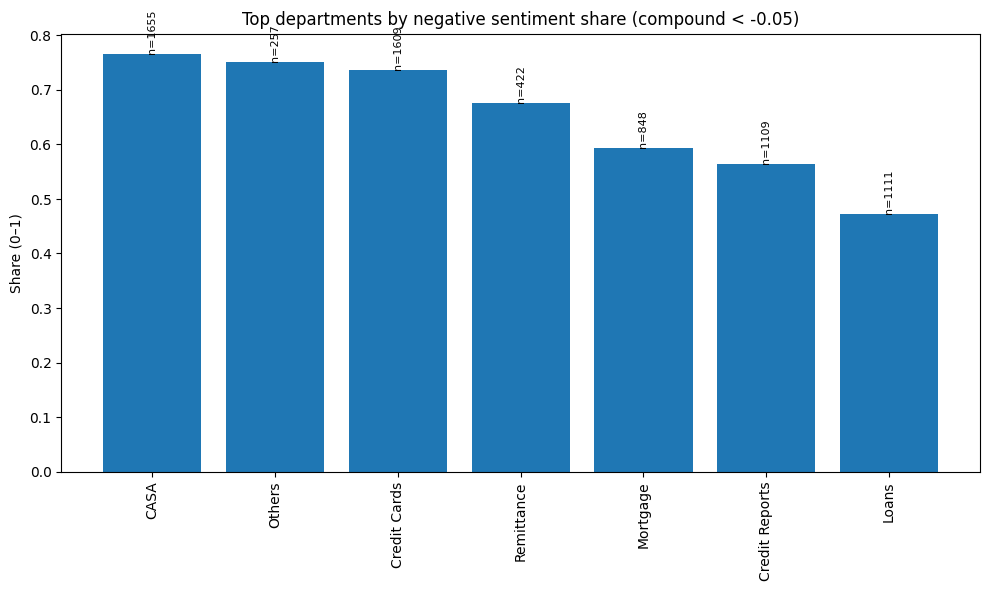

In [18]:

# Save Excel summary with multiple tabs
with pd.ExcelWriter(EXCEL_SUMMARY, engine="xlsxwriter") as writer:
    # dtypes
    dtypes_report.to_excel(writer, sheet_name="dtypes", index=False)
    # date range
    pd.DataFrame({
        "best_date_column":[best_date_col],
        "min_date":[min_date],
        "max_date":[max_date]
    }).to_excel(writer, sheet_name="date_range", index=False)
    # classification report
    report_df.to_excel(writer, sheet_name="classification_report")
    # top terms
    top_terms_df.to_excel(writer, sheet_name="top_terms_per_class")
    # sentiment by department
    sent_share.reset_index().to_excel(writer, sheet_name="sentiment_by_department", index=False)
    # sample scored rows
    cols_to_export = [chosen_text_col, "clean_text", chosen_target_col]
    for extra in ["pos","neg","neu","compound","sentiment_label"]:
        if extra in df_work.columns:
            cols_to_export.append(extra)
    df_work[cols_to_export].head(200).to_excel(writer, sheet_name="sample_scored", index=False)

# Build a ranked table with volume, then priority bands
# (uses the same target column you grouped by for `sent_share`)
counts = df_work[chosen_target_col].value_counts()

rank_df = (
    sent_share
    .join(counts.rename("n"))            # add sample size per department
    .assign(neg_share=lambda d: d["negative"])
    .sort_values(["neg_share", "n"], ascending=[False, False])
    .reset_index(names=[chosen_target_col])
)

action_table = (
    rank_df.assign(
        priority=pd.cut(
            rank_df["neg_share"],
            bins=[-1, 0.40, 0.60, 1.01],
            labels=["monitor", "focus", "critical"]
        )
    )
)

display(action_table.head(10))


# Recreate the negative-share chart and save
top10 = rank_df.head(10)
plt.figure(figsize=(10,6))
plt.bar(top10[chosen_target_col], top10["neg_share"])
plt.xticks(rotation=90)
plt.title("Top departments by negative sentiment share (compound < -0.05)")
plt.ylabel("Share (0–1)")
for i, r in top10.reset_index(drop=True).iterrows():
    plt.text(i, r["neg_share"], f"n={int(r['n'])}", ha="center", va="bottom", fontsize=8, rotation=90)
plt.tight_layout()
plt.show()



------
## 12. Actionable Business Strategies

**Signals used.** We use VADER compound sentiment on Complaint Description (negative if `compound < -0.05`) and the department classifier’s predictions.

### A) Triage & Routing (Day-to-day)
- **Priority rules**
  - **P1 (urgent):** `compound ≤ -0.40` OR text contains {“fraud”, “identity theft”, “account locked”, “chargeback”, “repossession”}.
  - **P2 (standard):** `-0.40 < compound < -0.05`.
- **Routing**
  - Route using the **department model**; if model confidence < 0.60, send to a **manual triage** queue.
- **SLA**
  - P1: first response **≤ 2h**; P2: **≤ 24h**. Escalate if breached.

### B) Hotspot Focus (Weekly)
- From `rank_df` (neg_share + volume), focus on **top 3** high-risk departments by **negative share** and **n**.
- For each, pull 20 recent P1 cases and label **root causes** (fees, login, charge disputes, mortgage payment errors, etc.). Create a 1-page fix plan per root cause.

### C) Early-Warning Dashboard (Daily)
- Track **7-day moving average** of negative share by department.
- **Alert rule:** trigger when 7-day avg > 30-day avg by **≥ 5 percentage points** (and n ≥ 50).
- Owner receives an alert with the offending **top terms** (from TF-IDF coefficients) and sample tickets.

### D) Proactive Communications (Playbooks)
- Auto-reply templates for frequent themes:
  - **Fees/charges:** clarify policy + immediate dispute link.
  - **Cards/fraud:** freeze option + re-issue flow + branch/phone escalation.
  - **Mortgage:** payment verification steps + hardship options.
- Send only for P2 cases; P1 gets human contact first.

### E) Agent Training & KB Updates (Bi-weekly)
- Use class-specific **top terms** to update knowledge-base articles and call scripts.
- Share **confusion matrix** insights with teams where misroutes are common; add 3 examples per failure mode.

### F) Measure Impact (Monthly)
- KPIs: avg **time-to-first-response**, **resolution time**, **reopen rate**, **escalation rate**, and department **negative share**.
- Success targets: −15% P1 volume in top-3 departments within 60 days; −10% negative share overall within 90 days.
- **Model refresh** when monthly accuracy drops > 3pp or drift in term distribution > 2σ.

> Governance: keep audit logs of auto-actions; sample 5% of automated cases for QA; review fairness across states/ZIPs.
